<a href="https://colab.research.google.com/github/npgeorge/DS-Unit-2-Applied-Modeling/blob/master/NHL_Data_Project_Game_Skater_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on the "goals" column for the Boston Bruins players.

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Step 2
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2.1 Get the file
downloaded = drive.CreateFile({'id':'1uy5TLljnscRGmsueO7G9QAwIPtUlGiAX'}) # replace the id with id of file you want to access
downloaded.GetContentFile('game_skater_stats.csv')

In [0]:
df = pd.read_csv('game_skater_stats.csv') 

In [7]:
df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2011030221,8467412,1,999,0,0,1,3,0,0,0,0,0,0,0,0,0,0,-1,885,98,16
1,2011030221,8468501,1,1168,0,0,0,4,0,0,0,0,0,1,1,0,0,1,0,767,401,0
2,2011030221,8470609,1,558,0,0,2,1,0,0,0,0,2,0,0,0,0,1,-1,542,0,16
3,2011030221,8471816,1,1134,0,0,1,4,0,0,0,0,0,1,0,0,0,1,-1,935,183,16
4,2011030221,8472410,1,436,0,0,1,3,0,0,0,3,6,0,0,0,0,0,-1,436,0,0


In [8]:
df.shape

(411578, 22)

In [9]:
#bruins filter
bruins_id_condition = (df['team_id'] == 6)
df_bruins = df[bruins_id_condition]
df_bruins.shape #ok so lets split the bruins in to train, val, and test

(14616, 22)

In [16]:
df_bruins.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
414,2010030311,8473419,6,1067,0,0,0,3,0,0,0,0,0,0,0,0,0,0,-2,953,114,0
415,2010030311,8469619,6,1570,0,0,2,1,0,0,0,0,0,0,1,0,0,1,-3,1150,203,217
416,2010030311,8471717,6,749,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,667,82,0
417,2010030311,8471276,6,1123,0,0,1,1,0,0,0,3,18,0,0,0,0,0,0,861,61,201
418,2010030311,8470187,6,1143,0,1,2,2,0,0,2,0,0,0,0,0,0,1,0,929,85,129


In [10]:
#baseline, can we beat the Bruins players baseline target?
#who will score the most goals per play?
baseline_target = 'goals'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

0    0.852422
1    0.131637
2    0.014368
3    0.001505
4    0.000068
Name: goals, dtype: float64

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test,  = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               random_state=42)
train.shape, test.shape

((11692, 22), (2924, 22))

In [31]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((9353, 22), (2339, 22))

In [0]:
train_features.select_dtypes(exclude='number').nunique()

In [0]:
#target and features
target = 'goals'
#drop target 
train_features = train.drop(columns=[target])
#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()
# only numerical features in data frame
features = num_feat 

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [41]:
!pip install category_encoders

     |████████████████████████████████| 102kB 3.3MB/s 


In [42]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=7, 
                           class_weight='balanced',
                           max_features=8, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

Training Accuracy 0.8260451192130868
Validation Accuracy 0.8071825566481402


In [43]:
from sklearn.metrics import accuracy_score
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

Test Accuracy for Random Forest 0.8026675786593708


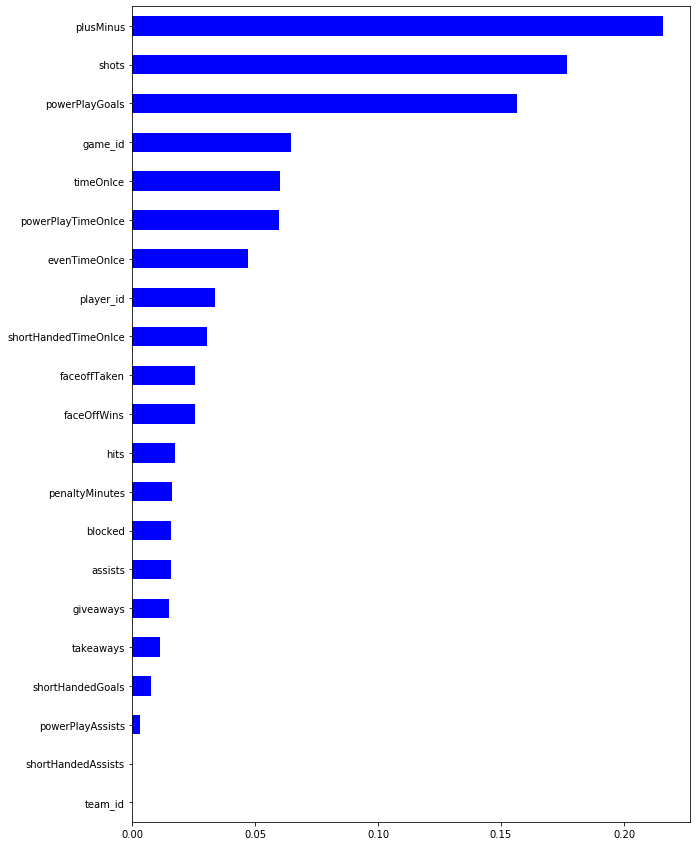

In [44]:
#feature importances
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values().plot.barh(color='blue');

In [45]:
#with XG Boost
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

#predict on test
y_pred_xgb = pipeline.predict(X_test)

Validation Accuracy: 0.8943993159469859


In [46]:
print('Test Accuracy for XG Boost', accuracy_score(y_test, y_pred_xgb))

Test Accuracy for XG Boost 0.8905608755129959


In [47]:
#permutation importance 
pipeline_pi = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline_pi.fit_transform(X_train)
X_val_transformed = pipeline_pi.transform(X_val)


model_pi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_pi.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
!pip install eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [49]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_pi,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [50]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0504 ± 0.0020,powerPlayGoals
0.0322 ± 0.0037,plusMinus
0.0119 ± 0.0054,shots
0.0108 ± 0.0015,shortHandedGoals
0.0091 ± 0.0024,assists
0.0042 ± 0.0029,player_id
0.0020 ± 0.0018,faceOffWins
0.0006 ± 0.0034,takeaways
0 ± 0.0000,team_id
-0.0000 ± 0.0011,powerPlayAssists
